# Gravity inversion with constructor function (and preconditioner)

In [1]:
import discretize
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200])  # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
h = [(5.0, 40)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 64,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40       -100.00        100.00      5.00      5.00    1.00
   y     40       -100.00        100.00      5.00      5.00    1.00
   z     40       -200.00          0.00      5.00      5.00    1.00

In [4]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [5]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [6]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [7]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7fafef17d160>,)

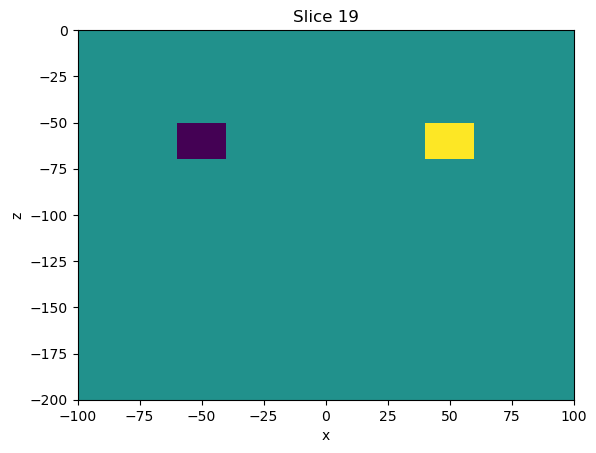

In [8]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [9]:
gz = simulation_simpeg.dpred(model)

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float32(2.5745852e-05)


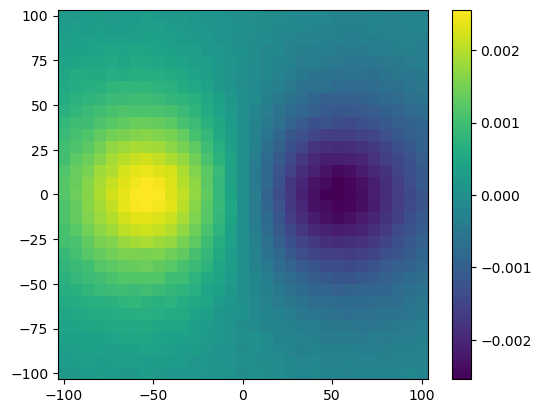

In [10]:
tmp = plt.pcolormesh(*coordinates[:2], gz.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Inversion

Define data misfit

In [11]:
simulation = ii.wrap_simulation(simulation_simpeg, store_jacobian=True)

In [12]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)

Define smallness term

In [13]:
volume_weights = mesh.cell_volumes
depth_weights = depth_weighting(mesh, 0)
smallness = ii.TikhonovZero(
    n_params=simulation.n_params, weights=volume_weights * depth_weights
)

Define inversion with constructor function

In [15]:
initial_model = np.zeros(simulation.n_params)

inversion = ii.create_inversion(
    data_misfit,
    smallness,
    starting_beta=1e4,
    initial_model=initial_model,
    minimizer=ii.conjugate_gradient,
    preconditioner="jacobi",
)

TypeError: Inversion.__init__() got an unexpected keyword argument 'preconditioner'

In [15]:
model = inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [16]:
inversion.stopping_criteria.info(model)

[x] ChiTarget
├── Condition: chi < chi_target
├── chi        = 4.81e-02
└── chi_target = 1.00e+00

In [17]:
log = inversion.log.to_pandas()
log

,beta,phi_d,phi_m,beta * phi_m,phi,chi
iter,,,,,,
0,10000.0,1.667546e+06,0.000000,0.000000,1.667546e+06,1735.219501
1,10000.0,4.624132e+01,0.430115,4301.150923,4.347392e+03,0.048118


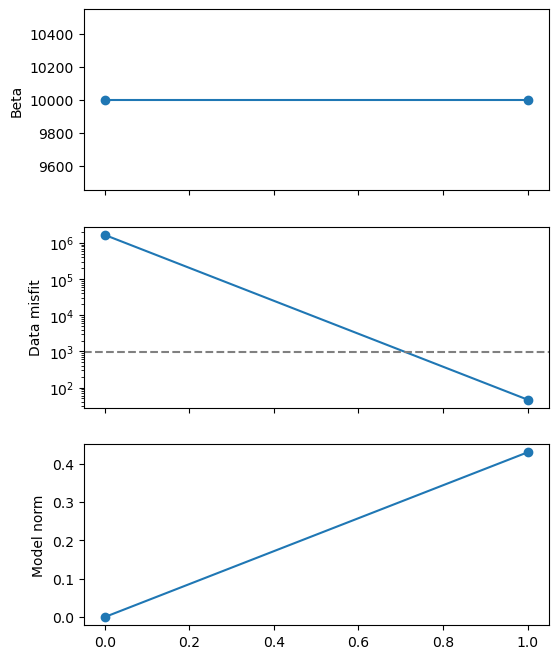

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(log.index, log.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(log.index, log.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

(<matplotlib.collections.QuadMesh at 0x7f6e7cbcb610>,)

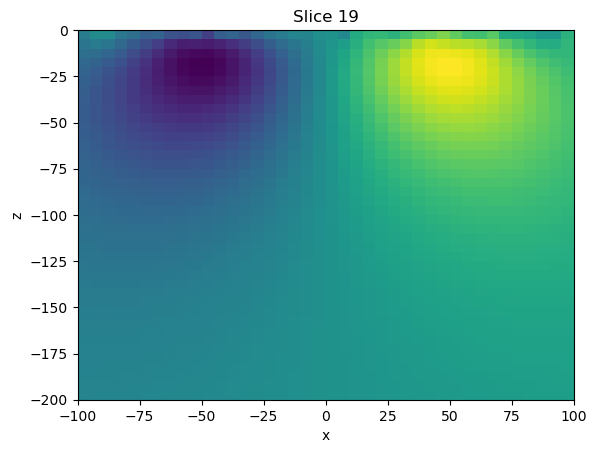

In [19]:
mesh.plot_slice(model, normal="Y", slice_loc=0)